In [1]:
### imports

# external modules
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
from sklearn.preprocessing import StandardScaler

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

2022-07-08 18:12:25.368996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

<module 'HyperRectangleFitter' from '/eos/home-k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Speed Controls and Run Mode

# Disables all plots for large datasets where speed is more important
createPlots = False

# Control for the notebook - turn off user-friendly mode to enable faster runtimes
userfriendly = True

In [3]:
### Evaluation Parameters

# Select the bias towards recall against precision, treated as a factor (so < 1 biases towards precision, 1 is equal importance, and > 1 biases towards recall)
wpBiasFactor = 20
fmBiasFactor = 2

In [4]:
### Defining bad runs
badruns = {'2017B':
                [
                    297048,
                    297282,
                    297283,
                    297284,
                    297287,
                    297288,
                    297289,
                    299316,
                    299317,
                    299318,
                    299324,
                    299326,
                    301086,
                    301086,
                    303948,
                    297047, #close but, true bad for all 8
                    297169, #true bad for all 8
                    297211, #Reconstructs well
                    299325, #Reconstructs well
                    297664, #true bad for all 8
                    299317, #true bad for all 8
                    297169, #true bad for all 8
                    297502
                ],
             '2017C':[
                  300781, # bad for tracking (pixels were excluded.
                  300079, # is bad for strips and then also for tracking
                  302029, # Poor detector elements for strips - Should be mildly anomalous, but technically good 
                  300576, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  300574, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  300282, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  301912, # Half bad for pixels (lost HV or readout card)  
                  301086, # Half bad for pixels (lost HV or readout card)  
                  300283, # Half bad for pixels (lost HV or readout card) 
                  300282, # Half bad for pixels (lost HV or readout card) 
                  300281, # Half bad for pixels (lost HV or readout card) 
                  300239, # Half bad for pixels (lost HV or readout card)
                  301394, # Marginal for pixels
                  301183, # Marginal for pixels
                  300398, # Marginal for pixels
                  300389, # Marginal for pixels
                  300365  # Marginal for pixels
             ],
             '2017E':[
                 304740, # Bad for pixels and tracking - holes in PXLayer 1
                 304776, # Bad for pixels and tracking - holes in PXLayer 1
                 304506, # Portcard problem for pixels
                 304507, # Portcard problem for pixels 
                 303989, # Bad for pixels, power supply died
                 303824  # Partly bad for strips due to a test
             ],
             '2017F':[
                 306422, # Partly bad for strips - 2 data readouts failed 
                 306423, # Partly bad for strips - 2 data readouts failed
                 306425, # Partly bad for strips - 2 data readouts failed
                 305440, # Partly bad for strips - 1 data readout failed
                 305441, # Partly bad for strips - 1 data readout failed
                 305249, # Bad for pixels - half of disk failed 
                 305250, # Bad for pixels - half of disk failed
                 305064, # Marginal for pixels - some readout failed
             ],
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                [
                317479,
                317480,
                317481,
                317482,
                319847
                ]}


In [26]:
### Select a reference run and get data
rundict = jsonu.loadjson('../jsons/CertHelperRefRuns.json')

runNum = 303824
runls = {}
for run in rundict:
    if run['run_number'] == runNum:
        runls.update(run)
if runls == {}:
    raise Exception('Run not found!')

year = runls['dataset'][11:15]
era = runls['dataset'][15]
ref_run = runls['reference_run_number']


outputRuns = {}
outputBad = {}
for run in rundict:
    tempRef = run['reference_run_number']
    if tempRef == ref_run:
        runls = {}
        runls[str(run['run_number'])] = [[-1]]
        if run['run_number'] in badruns[year+era]:
            print('Found bad run :' + str(run))
            outputBad.update(runls)
        else:
            outputRuns.update(runls)

# Perform structuring for compatibility with autoencoders
dataDict = {}
dataDict[year + era] = outputRuns

badrunsls = {}
badrunsls[year + era] = outputBad

trainrunsls = {}
goodrunsls = {}
trainrunsls[year + era] = {}
goodrunsls[year + era] = {}
for i,run in enumerate(dataDict[year + era]):
    if i > 5 and i < 11:
        goodrunsls[year + era][str(run)] = [[-1]]
    else:
        trainrunsls[year + era][str(run)] = [[-1]]

Found bad run :{'run_number': 303824, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}
Found bad run :{'run_number': 303989, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}
Found bad run :{'run_number': 304740, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}


In [27]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [
    ['NormalizedHitResiduals_TIB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
     'NormalizedHitResiduals_TIB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3' , 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'],
    ['chargeInner_PXLayer_1', 'chargeOuter_PXLayer_1', 'adc_PXLayer_1', 'size_PXLayer_1'],
#    ['chargeInner_PXLayer_2', 'chargeOuter_PXLayer_2', 'adc_PXLayer_2', 'size_PXLayer_2'],
#    ['chargeInner_PXLayer_3', 'chargeOuter_PXLayer_3', 'adc_PXLayer_3', 'size_PXLayer_3'],
#    ['chargeInner_PXLayer_4', 'chargeOuter_PXLayer_4', 'adc_PXLayer_4', 'size_PXLayer_4'],
#    ['charge_PXDisk_+1', 'adc_PXDisk_+1'],
#    ['charge_PXDisk_-1', 'adc_PXDisk_-1'],
#    ['charge_PXDisk_+2', 'adc_PXDisk_+2'],
#    ['charge_PXDisk_-2', 'adc_PXDisk_-2'],
#    ['charge_PXDisk_+3', 'adc_PXDisk_+3'],
#    ['charge_PXDisk_-3', 'adc_PXDisk_-3'],
#    ['NormalizedHitResiduals_TOB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2',
#     'NormalizedHitResiduals_TOB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3' , 'NormalizedHitResiduals_TOB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4']
]

# Read new data or use previously saved data & should data be saved
readnew = True
save = False

In [28]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Set whether to train globally or locally or in a development/testing mode
training_mode = 'development'

# Selects whether to create a new histstruct or use a saved one
readnew = True

# Select whether to save a new histstruct
save = False

In [29]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

In [30]:
### Define Training Mode Parameters - Combined Autoencoder
if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use averages of training set)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    # - this only works for a single era
    
    available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+era+'_'+histnames[0][0]+'.csv') ) )
    # Cherry picked really bad run
    run_application = 299316
    #run_application = 299317
    run_application_index = available_runs.index(run_application)
    # select training set
    usereference = False
    if usereference:
        run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
        if run_reference<0:
            raise Exception('no valid reference run has been defined for run {}'.format(run_application))
        runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
    else:
        ntraining = 5
        offset = 0 # normal case: offset = 0 (just use 5 previous runs)
        
        # Selects the 5 previous runs for training
        runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining-offset:run_application_index-offset]])
    #runsls_bad = badrunsls[year]
    #runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_bad = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_good = runsls_training
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)
        
elif training_mode == 'development':
    # train on a user-defined subset of runs
    
    # Select runs to be used in training from the user-defined list
    runsls_training = trainrunsls[year + era]
    # Select bad runs to test on in the user-defined list
    runsls_bad = badrunsls[year + era]
    # Select good runs to test on in the user-defined list
    runsls_good = goodrunsls[year + era]
    
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: 
{'303819': [[-1]], '303999': [[-1]], '304119': [[-1]], '304120': [[-1]], '304197': [[-1]], '304505': [[-1]], '304449': [[-1]], '304452': [[-1]], '304508': [[-1]], '304625': [[-1]], '304655': [[-1]], '304737': [[-1]], '304778': [[-1]], '306459': [[-1]], '304196': [[-1]]}
selected runs/lumisections as good test set:
{'304198': [[-1]], '304199': [[-1]], '304209': [[-1]], '304333': [[-1]], '304446': [[-1]]}
selected runs/lumisections as bad test set:
{'303824': [[-1]], '303989': [[-1]], '304740': [[-1]]}


In [31]:
### Data Import

# Create a new HistStruct from the data
if readnew:
    # Initializations
    dloader = DataLoader.DataLoader()
    histstruct = SubHistStruct.SubHistStruct()
    histstruct.reset_histlist(histnames)
    
    # Unpack histnames and add every histogram individually
    for histnamegroup in histnames:
        for histname in histnamegroup:
            print('Adding {}...'.format(histname))
            
            # Bring the histograms into memory from storage for later use
            filename = datadir + year + era + '/DF' + year + era + '_' + histname + '.csv'
            df = dloader.get_dataframe_from_file( filename )
            
            # In case of local training, we can remove most of the histograms
            if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
                runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
                df = dfu.select_runsls( df, runsls_total )    
                
            # Store the data in the histstruct object managing this whole thing
            histstruct.add_dataframe( df, rebinningfactor = 1, standardbincount = 102 )
    print('Found {} histograms'.format(len(histstruct.runnbs)))

# Load a previously saved HistStruct
else:
    # Load histstruct from storage
    histstruct = SubHistStruct.SubHistStruct.load( 'histstruct_global_20220201.zip', verbose=False )
    nbadruns = len([name for name in list(histstruct.masks.keys()) if ('bad' in name and name!='bad')])
    
    print('loaded a histstruct with the following properties:')
    print(histstruct)
    # Count of bad runs, presumably for later use
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
if userfriendly:
    print('Created a histstruct with the following properties:')
    print('- number of histogram types: {}'.format(len(histstruct.histnames)))
    print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))

Adding NormalizedHitResiduals_TIB__Layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__1...
Adding NormalizedHitResiduals_TIB__Layer__2...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__2...
Adding NormalizedHitResiduals_TIB__Layer__3...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__3...
Adding NormalizedHitResiduals_TIB__Layer__4...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__4...
Adding chargeInner_PXLayer_1...
Adding chargeOuter_PXLayer_1...
Adding adc_PXLayer_1...
Adding size_PXLayer_1...
Found 9290 histograms
Created a histstruct with the following properties:
- number of histogram types: 12
- number of lumisections: 9290


In [32]:
### Add Masks to Data

if readnew:
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_highstat_mask( 'highstat' )
    histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        print(runsls_bad)
        histstruct.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct.save('test.pk1')
if userfriendly: print('Assigned masks: {}'.format(list(histstruct.masks.keys())))

{'303824': [[-1]], '303989': [[-1]], '304740': [[-1]]}
Assigned masks: ['dcson', 'golden', 'highstat', 'lowstat', 'training', 'good', 'bad', 'bad0', 'bad1', 'bad2']


In [33]:
### Plotting the input data for analysis

if((training_mode=='local' or training_mode == 'development') and createPlots):

    # training and application runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','training'],['dcson','highstat','good']],
                                labellist = ['training','testing'],
                                colorlist = ['blue','green']
                              )
    
    # application run and bad test runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad0']],
                                labellist = ['good','bad'],
                                colorlist = ['green','red']
                              )
    
elif( training_mode=='global' and createPlots):
    
    # bad test runs
    for i in [0,1,2,3,4,5,6]:
        histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad{}'.format(i)]],
                                labellist = ['typical good histograms','bad'],
                                colorlist = ['blue','red'],
                                transparencylist = [0.01,1.]
                                    )

In [34]:
def define_concatamash_autoencoder(histstruct):
    
    histslist = []
    vallist = []
    autoencoders = []
    if trainnew:
        for i,histnamegroup in enumerate(histnames):
            
            train_normhist = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'training']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
            X_train, X_val = train_test_split(train_normhist, test_size=0.4, random_state=42)
            
            if userfriendly:
                print('\nNow Defining model {}/'.format(i + 1) 
                      + str(len(histnames)))
                print(' - Size of training set: {}'.format(X_train.shape))
            
            # Half the total bin count
            arch = 51 * len(histnamegroup)
            
            ## Model parameters
            print(X_train.shape)
            
            input_dim = X_train.shape[2] #num of predictor variables
            Input_layers=[Input(shape=input_dim) for i in range((X_train.shape[1]))]
            
            # Defining layers
            conc_layer = Concatenate()(Input_layers)
            encoder = Dense(arch * 2, activation="tanh")(conc_layer)
            #encoder = Dense(128, activation='relu')(encoder)
            #
            #encoder = Dense(32, activation='relu')(encoder)
            
            decoder = Dense(arch, activation="relu")(encoder)
            #decoder = Dense(256, activation="tanh")(decoder)
            
            Output_layers=[Dense(input_dim, activation="tanh")(decoder) for i in range(X_train.shape[1])]

            autoencoder = Model(inputs=Input_layers, outputs=Output_layers)
            autoencoder.summary()
            autoencoders.append(autoencoder)
            
            histslist.append(X_train)
            vallist.append(X_val)
     
    # Return the histograms stored 2-Dimensionally and the autoencoders corresponding
    return(histslist, vallist, autoencoders, train_normhist)

In [35]:
(histslist, vallist, autoencoders, train_normhist) = define_concatamash_autoencoder(histstruct)


Now Defining model 1/2
 - Size of training set: (2926, 8, 102)
(2926, 8, 102)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 102)]        0                                            
_____________

In [36]:
### Trains a combined autoencoder for every merge set
def train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders):
    
    # Iterate through the training data to train corresponding autoencoders
    for i in range(len(histslist)):
        
        if userfriendly: print('\nNow training model {}/'.format(i + 1) + str(len(histslist)))
        
        # Set variables to temporary values for better transparency
        X_train = histslist[i]
        X_val = vallist[i]
        autoencoder = autoencoders[i]
        
        
        ## Model parameters
        nb_epoch = 500
        batch_size = 500
        
        #checkpoint_filepath = 'checkpoint'
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #   filepath=checkpoint_filepath,
        #   save_weights_only=False,
        #   verbose=1,
        #   save_best_only=True,
        #   monitor='val_loss',
        #   mode='min')
        
        # Tell the model when to stop
        earlystop = EarlyStopping(monitor='val_loss',
            min_delta=1e-7,
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
        )
        lr =0.001
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        autoencoder.compile(loss='mse',
                            optimizer=opt)
        
        ## Train autoencoder
        train = autoencoder.fit(x=[X_train[:,i] for i in range(X_train.shape[1])],
                                y=[X_train[:,i] for i in range(X_train.shape[1])],
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=([X_val[:,i] for i in range(X_val.shape[1])], [X_val[:,i] for i in range(X_val.shape[1])]),
                            verbose=1,
                            callbacks= [earlystop],    
                            )
        
        # Create a plot of the model
        
        tf.keras.utils.plot_model(
            autoencoder,
            to_file="models/modelConcatamash{}.png".format(i),
            show_shapes=True,
            show_dtype=False,
            show_layer_names=False,
            rankdir="TB")
        
        # Save classifier for evaluation
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier)
        if savemodel:
            autoencoder.save('../SavedModels/Concatamash' + '/AE' + str(j))

In [37]:
start = time.perf_counter()
train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders)
stop = time.perf_counter()
print(stop - start)


Now training model 1/2
Epoch 1/500
6/6 [==============================] - 4s 192ms/step - loss: 0.0029 - dense_18_loss: 2.6497e-04 - dense_19_loss: 3.8351e-04 - dense_20_loss: 2.9741e-04 - dense_21_loss: 4.4036e-04 - dense_22_loss: 3.4179e-04 - dense_23_loss: 4.0342e-04 - dense_24_loss: 3.1901e-04 - dense_25_loss: 4.1125e-04 - val_loss: 0.0014 - val_dense_18_loss: 1.1608e-04 - val_dense_19_loss: 1.8701e-04 - val_dense_20_loss: 1.1728e-04 - val_dense_21_loss: 2.2729e-04 - val_dense_22_loss: 1.5573e-04 - val_dense_23_loss: 2.2247e-04 - val_dense_24_loss: 1.3995e-04 - val_dense_25_loss: 2.1350e-04
Epoch 2/500
6/6 [==============================] - 0s 63ms/step - loss: 8.9022e-04 - dense_18_loss: 7.0477e-05 - dense_19_loss: 1.2682e-04 - dense_20_loss: 7.8816e-05 - dense_21_loss: 1.4315e-04 - dense_22_loss: 1.0668e-04 - dense_23_loss: 1.3036e-04 - dense_24_loss: 8.8338e-05 - dense_25_loss: 1.4558e-04 - val_loss: 3.4678e-04 - val_dense_18_loss: 2.3184e-05 - val_dense_19_loss: 5.2254e-05 - v

Epoch 15/500
6/6 [==============================] - 0s 75ms/step - loss: 3.4153e-06 - dense_18_loss: 2.3419e-07 - dense_19_loss: 9.1941e-07 - dense_20_loss: 2.4498e-07 - dense_21_loss: 4.8452e-07 - dense_22_loss: 3.3033e-07 - dense_23_loss: 4.7224e-07 - dense_24_loss: 2.9140e-07 - dense_25_loss: 4.3826e-07 - val_loss: 4.5035e-06 - val_dense_18_loss: 4.2493e-07 - val_dense_19_loss: 1.0554e-06 - val_dense_20_loss: 3.2778e-07 - val_dense_21_loss: 6.1125e-07 - val_dense_22_loss: 4.9178e-07 - val_dense_23_loss: 5.8087e-07 - val_dense_24_loss: 4.4543e-07 - val_dense_25_loss: 5.6602e-07
Epoch 16/500
6/6 [==============================] - 0s 71ms/step - loss: 4.4775e-06 - dense_18_loss: 4.3395e-07 - dense_19_loss: 1.0664e-06 - dense_20_loss: 3.4337e-07 - dense_21_loss: 5.9211e-07 - dense_22_loss: 4.5994e-07 - dense_23_loss: 5.7695e-07 - dense_24_loss: 4.5448e-07 - dense_25_loss: 5.5036e-07 - val_loss: 2.8661e-06 - val_dense_18_loss: 1.7613e-07 - val_dense_19_loss: 8.1994e-07 - val_dense_20_los

Epoch 29/500
6/6 [==============================] - 0s 67ms/step - loss: 5.4765e-06 - dense_18_loss: 4.9184e-07 - dense_19_loss: 1.2779e-06 - dense_20_loss: 5.0371e-07 - dense_21_loss: 7.3729e-07 - dense_22_loss: 6.4041e-07 - dense_23_loss: 7.0378e-07 - dense_24_loss: 5.2918e-07 - dense_25_loss: 5.9240e-07 - val_loss: 6.0916e-06 - val_dense_18_loss: 7.1156e-07 - val_dense_19_loss: 1.2910e-06 - val_dense_20_loss: 4.7242e-07 - val_dense_21_loss: 8.3678e-07 - val_dense_22_loss: 6.6483e-07 - val_dense_23_loss: 8.0590e-07 - val_dense_24_loss: 5.4252e-07 - val_dense_25_loss: 7.6663e-07
Epoch 30/500
6/6 [==============================] - 0s 65ms/step - loss: 9.2106e-06 - dense_18_loss: 1.1155e-06 - dense_19_loss: 1.6444e-06 - dense_20_loss: 8.4064e-07 - dense_21_loss: 1.2009e-06 - dense_22_loss: 1.1192e-06 - dense_23_loss: 1.0885e-06 - dense_24_loss: 9.1668e-07 - dense_25_loss: 1.2847e-06 - val_loss: 7.9905e-06 - val_dense_18_loss: 7.3990e-07 - val_dense_19_loss: 1.4155e-06 - val_dense_20_los

Epoch 43/500
6/6 [==============================] - 0s 65ms/step - loss: 3.0577e-06 - dense_18_loss: 2.2938e-07 - dense_19_loss: 7.9987e-07 - dense_20_loss: 2.3564e-07 - dense_21_loss: 3.9948e-07 - dense_22_loss: 3.0051e-07 - dense_23_loss: 4.2643e-07 - dense_24_loss: 3.0433e-07 - dense_25_loss: 3.6210e-07 - val_loss: 2.7227e-06 - val_dense_18_loss: 1.7931e-07 - val_dense_19_loss: 7.3336e-07 - val_dense_20_loss: 1.9848e-07 - val_dense_21_loss: 3.7060e-07 - val_dense_22_loss: 2.5850e-07 - val_dense_23_loss: 3.8740e-07 - val_dense_24_loss: 2.6363e-07 - val_dense_25_loss: 3.3139e-07
Epoch 44/500
6/6 [==============================] - 0s 63ms/step - loss: 2.7824e-06 - dense_18_loss: 1.7902e-07 - dense_19_loss: 7.4765e-07 - dense_20_loss: 2.0772e-07 - dense_21_loss: 3.7909e-07 - dense_22_loss: 2.6381e-07 - dense_23_loss: 3.9261e-07 - dense_24_loss: 2.7174e-07 - dense_25_loss: 3.4075e-07 - val_loss: 2.6916e-06 - val_dense_18_loss: 1.7297e-07 - val_dense_19_loss: 7.1758e-07 - val_dense_20_los

Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping

Now training model 2/2
Epoch 1/500
6/6 [==============================] - 2s 103ms/step - loss: 0.0024 - dense_28_loss: 4.0423e-04 - dense_29_loss: 3.2125e-04 - dense_30_loss: 6.1134e-04 - dense_31_loss: 0.0011 - val_loss: 0.0015 - val_dense_28_loss: 1.8458e-04 - val_dense_29_loss: 1.6109e-04 - val_dense_30_loss: 3.8019e-04 - val_dense_31_loss: 8.1060e-04
Epoch 2/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0012 - dense_28_loss: 1.3886e-04 - dense_29_loss: 1.3142e-04 - dense_30_loss: 2.8883e-04 - dense_31_loss: 6.4401e-04 - val_loss: 7.3698e-04 - val_dense_28_loss: 8.2649e-05 - val_dense_29_loss: 8.3000e-05 - val_dense_30_loss: 1.4952e-04 - val_dense_31_loss: 4.2181e-04
Epoch 3/500
6/6 [==============================] - 0s 21ms/step - loss: 5.0965e-04 - dense_28_loss: 5.8956e-05 - dense_29_loss: 5.8899e-05 - dense_30_loss: 9.0937e-05 - dense_31_loss: 3.0086e-04 - val_loss: 2.7339e-

6/6 [==============================] - 0s 25ms/step - loss: 1.0159e-05 - dense_28_loss: 4.1378e-06 - dense_29_loss: 1.8229e-06 - dense_30_loss: 8.2149e-07 - dense_31_loss: 3.3765e-06 - val_loss: 1.0224e-05 - val_dense_28_loss: 4.1610e-06 - val_dense_29_loss: 1.8081e-06 - val_dense_30_loss: 8.2748e-07 - val_dense_31_loss: 3.4270e-06
Epoch 25/500
6/6 [==============================] - 0s 22ms/step - loss: 1.0050e-05 - dense_28_loss: 4.0789e-06 - dense_29_loss: 1.7989e-06 - dense_30_loss: 8.2695e-07 - dense_31_loss: 3.3450e-06 - val_loss: 1.0101e-05 - val_dense_28_loss: 4.0957e-06 - val_dense_29_loss: 1.7802e-06 - val_dense_30_loss: 8.3312e-07 - val_dense_31_loss: 3.3917e-06
Epoch 26/500
6/6 [==============================] - 0s 29ms/step - loss: 9.9324e-06 - dense_28_loss: 4.0153e-06 - dense_29_loss: 1.7716e-06 - dense_30_loss: 8.3461e-07 - dense_31_loss: 3.3109e-06 - val_loss: 9.9765e-06 - val_dense_28_loss: 4.0272e-06 - val_dense_29_loss: 1.7534e-06 - val_dense_30_loss: 8.4192e-07 - va

Epoch 48/500
6/6 [==============================] - 0s 29ms/step - loss: 3.2715e-06 - dense_28_loss: 9.1302e-07 - dense_29_loss: 6.0319e-07 - dense_30_loss: 6.4193e-07 - dense_31_loss: 1.1134e-06 - val_loss: 3.1073e-06 - val_dense_28_loss: 8.5788e-07 - val_dense_29_loss: 5.6975e-07 - val_dense_30_loss: 6.2024e-07 - val_dense_31_loss: 1.0594e-06
Epoch 49/500
6/6 [==============================] - 0s 19ms/step - loss: 2.9782e-06 - dense_28_loss: 8.1269e-07 - dense_29_loss: 5.5979e-07 - dense_30_loss: 6.0320e-07 - dense_31_loss: 1.0026e-06 - val_loss: 2.8234e-06 - val_dense_28_loss: 7.6436e-07 - val_dense_29_loss: 5.2882e-07 - val_dense_30_loss: 5.8021e-07 - val_dense_31_loss: 9.5002e-07
Epoch 50/500
6/6 [==============================] - 0s 25ms/step - loss: 2.7121e-06 - dense_28_loss: 7.2539e-07 - dense_29_loss: 5.2093e-07 - dense_30_loss: 5.6422e-07 - dense_31_loss: 9.0157e-07 - val_loss: 2.5600e-06 - val_dense_28_loss: 6.8123e-07 - val_dense_29_loss: 4.8854e-07 - val_dense_30_loss: 5.

Epoch 72/500
6/6 [==============================] - 0s 30ms/step - loss: 1.6522e-06 - dense_28_loss: 4.3818e-07 - dense_29_loss: 3.7552e-07 - dense_30_loss: 4.0480e-07 - dense_31_loss: 4.3366e-07 - val_loss: 1.4568e-06 - val_dense_28_loss: 3.9272e-07 - val_dense_29_loss: 3.3052e-07 - val_dense_30_loss: 3.5097e-07 - val_dense_31_loss: 3.8261e-07
Epoch 73/500
6/6 [==============================] - 0s 18ms/step - loss: 1.4529e-06 - dense_28_loss: 3.8497e-07 - dense_29_loss: 3.3393e-07 - dense_30_loss: 3.5317e-07 - dense_31_loss: 3.8085e-07 - val_loss: 1.4717e-06 - val_dense_28_loss: 3.9070e-07 - val_dense_29_loss: 3.4131e-07 - val_dense_30_loss: 3.5521e-07 - val_dense_31_loss: 3.8451e-07
Epoch 74/500
6/6 [==============================] - 0s 26ms/step - loss: 1.4588e-06 - dense_28_loss: 3.8410e-07 - dense_29_loss: 3.3710e-07 - dense_30_loss: 3.5661e-07 - dense_31_loss: 3.8098e-07 - val_loss: 1.3648e-06 - val_dense_28_loss: 3.6844e-07 - val_dense_29_loss: 3.0933e-07 - val_dense_30_loss: 3.

In [38]:
### Evaluate the Models for WP definition
def evaluate_models_train(histstruct):
    
    for histgroup in histnames:
        print('evaluating model for '+histgroup[0])
        print(histstruct.evaluate_classifier(histgroup)[0].shape)
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histname in histstruct.histnames:
            mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct.histnames:
            hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [39]:
(mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train(histstruct)

evaluating model for NormalizedHitResiduals_TIB__Layer__1
(9290,)
evaluating model for chargeInner_PXLayer_1
(9290,)
Found mse array for training set of following shape: (4878, 12)
Found mse array for good set of following shape: (2091, 12)
Found mse array for bad set of following shape: (604, 12)
Found mse array for bad set of following shape: (103, 12)
Found mse array for bad set of following shape: (278, 12)


In [40]:
### Plots and Distribution Analysis
def fit_mse_distribution(histstruct, mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = len(histstruct.histnames)
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    #for dims in dimslist:
    #    thismse = mse_train[:,dims]
    #    if training_mode=='global': 
    #        fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    #        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
    #        #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
    #        #                                                    'up')
    #    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    #    #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
    #    #                onlycontour=False, xlims=30, ylims=30, 
    #    #                onlypositive=True, transparency=0.5,
    #    #                xaxtitle=histstruct.histnames[dims[0]], 
    #    #                yaxtitle=histstruct.histnames[dims[1]],
    #    #                title='density fit of lumisection MSE')
    #    ##plt.close('all') # release plot memory
    #    fitfunclist.append(fitfunc)
    # 
    #    
    if training_mode=='global': 
        fitfunc = SeminormalFitter.SeminormalFitter(mse_train)
        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(mse_train, quantiles, 'up')
    else: 
        fitfunc = GaussianKdeFitter.GaussianKdeFitter()
        fitfunc.fit(mse_train,bw_method=bw_method)
    
    return fitfunc

In [41]:
fitfunc = fit_mse_distribution(histstruct, mse_train)

In [42]:
### Prepare MSEs for Working Point Definition
def mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    print('--- good lumesections ---')
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    print('length of log prob array: '+str(len(logprob_good)))
    print('minimum of log prob: '+str(np.min(logprob_good)))
    #print(sorted(logprob_good))
    
    print('--- bad lumisections ---')
    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts))
    
    print('length of log prob array: '+str(len(logprob_bad)))
    print('maximum of log prob: '+str(np.max(logprob_bad)))
    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    #print(logprob_bad)
    
    sep = np.min(logprob_good) - np.max(logprob_bad)
    print('Separability: ' + str(sep))
    
    return [logprob_good, logprob_bad]

In [43]:
(logprob_good, logprob_bad) = mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc)

--- good lumesections ---
length of log prob array: 2091
minimum of log prob: 127.85388830818651
--- bad lumisections ---


/tmp/ipykernel_27974/2141632033.py:12: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]


length of log prob array: 985
maximum of log prob: 131.47420506398103
Separability: -3.6203167557945193


In [44]:
def evaluate_autoencoder_individual(histstruct):
    
    msewps = []
    for histname in histstruct.histnames:
        
        # Get histograms from histstruct
        X_test_good = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'good']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        X_test_bad = X_test_bad = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'bad']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        # Get each model from the histstruct
        autoencoder = histstruct.get_classifier(histname)
        
        # Getting evaluation criteria
        prediction_test_good = autoencoder.reconstruct(X_test_good)
        mse_test_good = aeu.mseTopNRaw(X_test_good, prediction_test_good, n=10 )
        prediction_test_bad = autoencoder.reconstruct(X_test_bad)
        mse_test_bad = aeu.mseTopNRaw(X_test_bad, prediction_test_bad, n=10 )
        
        if userfriendly:
            print('Average MSE on good set: ' + str(np.mean(mse_test_good)))
            print('Average MSE on bad set: ' + str(np.mean(mse_test_bad)))
        
        if createPlots:
            # Number of plots of each type to generate per model (so nplot * 2 * len(model))
            nplot = 3
            
            # Good examples
            print('Examples of good histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_good)),size=nplot,replace=False)
            for i in randint: 
                histlist = [X_test_good[int(i),:],prediction_test_good[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
            
            # Bad examples
            print('Examples of bad histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_bad)),size=nplot,replace=False)
            for i in randint:
                histlist = [X_test_bad[int(i),:],prediction_test_bad[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
        
        # Attaching the bad histograms as a new set of rows under the good histograms
        validation_data = np.vstack((X_test_good, X_test_bad))
        validation_preds = np.vstack((prediction_test_good, prediction_test_bad))
        # Creating labels to differentiate the data when we go to compare predictions
        #     with actual label
        labels = np.hstack((np.zeros(len(X_test_good)), np.ones(len(X_test_bad))))
        
        # Pick a working point to see 
        msewp = 0.5*(np.mean(mse_test_bad) - np.mean(mse_test_good))
        print("Selected working point: " + str(msewp))
        
        # Get data to pick a good working point for future evaluation
        scores = aeu.mseTop10Raw(validation_data, validation_preds)
        nsig = np.sum(labels)
        nback = np.sum(1-labels)
        
        # Get some metrics for the user
        tp = np.sum(np.where((labels==1) & (scores>msewp),1,0))/nsig
        fp = np.sum(np.where((labels==0) & (scores>msewp),1,0))/nback
        tn = 1-fp
        fn = 1-tp
        
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2*precision*recall) / (precision + recall)
        
        if userfriendly:
            print(accuracy)
            print(precision)
            print(recall)
            print(f1)
        
    return msewps

In [53]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, -1))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, 10001))
    
    logprob_good = np.where(logprob_good != np.inf, logprob_good, goodMax)
    logprob_bad = np.where(logprob_bad != -np.inf, logprob_bad, badMin)
    
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good == -np.inf] = badMin
    logprob_bad[logprob_bad == np.inf] = goodMax
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    print('Average Separation: ' + str(avSep))
    
    pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)')
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 100
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold

Average Separation: 180.84337670762622


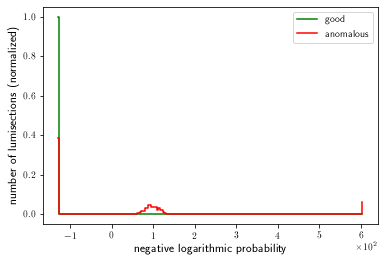

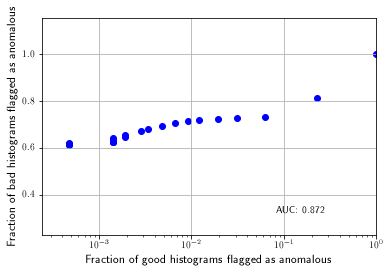

Selected logprob threshold of 122.81446766362305
Accuracy: 0.8065989847715735
Precision: 1.0
Recall: 0.6131979695431472
F-Measure: 0.664612676056338


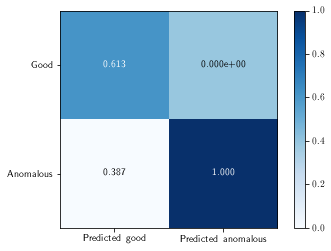

In [54]:
logprob_threshold = evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor)